In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')


In [3]:
from src_dir import *
import numpy as np

dim=125
x0=np.squeeze(np.zeros((dim,1)))
x0Type='Zero Vector'

# FD_StencilMat=np.zeros((dim,dim))
# b = np.ones(dim-1)
# c = -2*np.ones(dim)
# np.fill_diagonal(FD_StencilMat[1:], b)
# np.fill_diagonal(FD_StencilMat[:,1:], b)
# np.fill_diagonal(FD_StencilMat, c)
# A=FD_StencilMat
# A=np.asmatrix(A)
A=mk_laplace_1d(dim)
AType='1D Laplacian'

retrain_freq=1
e1 = 1e-3
e2 = 1e-5
nmax_iter = 50
restart   = 64

sigma=0.02
DomainL=-5.0
DomainR=5.0
x=np.linspace(DomainL,DomainR,dim)



n_steps =500
InputDim=dim
HiddenDim=dim
OutputDim=dim

In [4]:
# Initial log message
logger.info("Benchmark 125 dim problem. Linear gradient RHS. Test 1D linop. Benchmark on Kevin's PC. Set time cutoff to 0.05. PRELU. Batch 128. Set e1=10-3. Set epochs to 2000. Set e2=10-5")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-06-16 23:58:01 [INFO] <ipython-input-4-3f38537dd2d1> 2 - Benchmark 125 dim problem. Linear gradient RHS. Test 1D linop. Benchmark on Kevin's PC. Set time cutoff to 0.05. PRELU. Batch 128. Set e1=10-3. Set epochs to 2000. Set e2=10-5


In [5]:
from src_dir import *

# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
@cnn_preconditionerOnline_timed(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b, x0, e, nmax_iter,ML_GMRES_Time_list,ProbCount,restart,debug,refine,blist,reslist,Err_list):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [6]:
from src_dir import *



ML_GMRES_Time_list=[]

Err_list=[]
NonML_Err_List=[]

run_time_ML_list=[]
run_timeP1_ML_list=[]
run_timeP2_ML_list=[]

run_time_list=[]
GmresRunTimeOriginal=[]
GmresRunTimeOriginal2=[]

trainTime_list=[]


debug=True
refine1=False
refine2=True

blist=[]
reslist=[]



for ProbIdx in range(n_steps):

    loc=4*np.sin(0.5*ProbIdx*np.abs(np.cos(0.5*ProbIdx)))
#     b=Gauss_pdf(x,loc,sigma)
    b=(np.sin(ProbIdx)+.0001)*np.maximum(x-loc,0)
    b_norm=np.linalg.norm(b)


    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine1,blist,reslist,Err_list)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    ML_GMRES_Time_list=OutList1[1]
    blist=OutList1[3]
    reslist=OutList1[4]
    Err_list=OutList1[5]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm, Out[-1], e2, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine2,blist,reslist,Err_list)
    Out2=OutList2[0]
    ML_GMRES_Time_list=OutList2[1]
    trainTime_list.append(OutList2[2])
    blist=OutList2[3]
    reslist=OutList2[4]
    Err_list=OutList2[5]

    run_timeP1_ML_list.append(run_time1_ML)
    run_timeP2_ML_list.append(run_time2_ML)
    run_time_ML_list.append(run_time1_ML+run_time2_ML)
    



    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[50])
   
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    
    GmresRunTimeOriginal.append(run_time1)
    GmresRunTimeOriginal2.append(run_time2)
    run_time_list.append(run_time1+run_time2)
    
    print(ProbIdx)


run_time=sum(run_time_list)
run_time_ML=sum(run_time_ML_list)
trainTime_total=sum(trainTime_list)


logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)


logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)



0
1
Final loss: 5532.521484375
parameters 31375
Initial Training
2
size 52
0.01783876040337512 0.33671211134332835
0.2234954879968427 0.43593418500677217 0.01783876040337512 0.22228070966830826
0.2234954879968427 0.43593418500677217 0.01783876040337512 0.22228070966830826
3
size 52
0.036046958724355524 0.33671211134332835
0.22872191201895475 0.36148969500209205 0.036046958724355524 0.1139966692105183
0.22872191201895475 0.36148969500209205 0.036046958724355524 0.1139966692105183
4
size 52
0.030831497406659452 0.33671211134332835
0.27390361900324933 0.3172337673410463 0.030831497406659452 0.08801343238179737
0.27390361900324933 0.3172337673410463 0.030831497406659452 0.08801343238179737
5
size 52
0.07950217978809618 0.33671211134332835
0.38007654997636564 0.2420403396730156 0.07950217978809618 0.028239072178130032
0.38007654997636564 0.2420403396730156 0.07950217978809618 0.028239072178130032
6
size 52
0.05245568660990939 0.33671211134332835
0.31315203598933294 0.2765493922488531 0.0524

0.12213684798916802 0.28651710035977884 0.014614694217416567 0.054853829315737554
39
size 52
0.054058749692235314 0.33671211134332835
0.35867441300069913 0.2694939971587155 0.054058749692235314 0.04778216300818365
0.35867441300069913 0.2694939971587155 0.054058749692235314 0.04778216300818365
40
size 52
0.05411601038811447 0.33671211134332835
0.2753898249939084 0.27629224491887727 0.05411601038811447 0.04914609806792664
0.2753898249939084 0.27629224491887727 0.05411601038811447 0.04914609806792664
41
size 52
0.028559228733691402 0.33671211134332835
0.16012988999136724 0.2734214620385319 0.028559228733691402 0.04943994749231078
0.16012988999136724 0.2734214620385319 0.028559228733691402 0.04943994749231078
42
size 52
0.009087513661598694 0.33671211134332835
0.1802572319866158 0.2573538830783218 0.009087513661598694 0.04313730398983186
0.1802572319866158 0.2573538830783218 0.009087513661598694 0.04313730398983186
43
size 52
0.02472795922687897 0.33671211134332835
0.17370811197906733 0.25

0.08792108600027859 0.17202286076266318 0.01083053284328737 0.017431126042128476
76
size 52
0.018246110738571315 0.33671211134332835
0.0881779560004361 0.16999901504255832 0.018246110738571315 0.01736707105788601
0.0881779560004361 0.16999901504255832 0.018246110738571315 0.01736707105788601
77
size 52
0.006527231053406297 0.33671211134332835
0.1649530889990274 0.16440533712273464 0.006527231053406297 0.017815322532183223
0.1649530889990274 0.16440533712273464 0.006527231053406297 0.017815322532183223
78
size 52
0.007670991405025447 0.33671211134332835
0.2202919160190504 0.16723518624319694 0.007670991405025447 0.017656067396795684
0.2202919160190504 0.16723518624319694 0.007670991405025447 0.017656067396795684
79
size 52
0.02012265961018034 0.33671211134332835
0.1312841299804859 0.16722886428353376 0.02012265961018034 0.015794889917786034
0.1312841299804859 0.16722886428353376 0.02012265961018034 0.015794889917786034
80
size 52
0.008961550099409984 0.33671211134332835
0.17572568598552

0.22195438598282635 0.13808427860261874 0.009724252526358935 0.012846608035777711
0.22195438598282635 0.13808427860261874 0.009724252526358935 0.012846608035777711
113
size 52
0.010126288107340214 0.33671211134332835
0.17754452899680473 0.14025531540159136 0.010126288107340214 0.012566370376341228
0.17754452899680473 0.14025531540159136 0.010126288107340214 0.012566370376341228
114
size 52
0.010633630063547488 0.33671211134332835
0.12872671301010996 0.1402526364813093 0.010633630063547488 0.012289466342578255
0.12872671301010996 0.1402526364813093 0.010633630063547488 0.012289466342578255
115
size 52
0.005132215055971631 0.33671211134332835
0.08669909799937159 0.14210073184221983 0.005132215055971631 0.01230182487686914
0.08669909799937159 0.14210073184221983 0.005132215055971631 0.01230182487686914
116
size 52
0.005262793677138461 0.33671211134332835
0.11109976301668212 0.13885828980244697 0.005262793677138461 0.012232704984845997
0.11109976301668212 0.13885828980244697 0.005262793677

0.13554308799211867 0.13532095792121254 0.004371215297454945 0.008230680125509537
150
size 52
0.010138308039504593 0.33671211134332835
0.13599263501237147 0.13555510336183943 0.010138308039504593 0.008200341404137872
0.13599263501237147 0.13555510336183943 0.010138308039504593 0.008200341404137872
151
size 52
0.007987205550590187 0.33671211134332835
0.1280185889918357 0.13439335620147175 0.007987205550590187 0.007950707588495249
0.1280185889918357 0.13439335620147175 0.007987205550590187 0.007950707588495249
152
size 52
0.0056592241041403465 0.33671211134332835
0.11108052398776636 0.13289872004068456 0.0056592241041403465 0.007414332077986432
0.11108052398776636 0.13289872004068456 0.0056592241041403465 0.007414332077986432
153
size 52
0.0037182174274686098 0.33671211134332835
0.08413956000003964 0.13220584255992435 0.0037182174274686098 0.00725820360797496
0.08413956000003964 0.13220584255992435 0.0037182174274686098 0.00725820360797496
154
size 52
0.008212842313002757 0.3367121113433

186
size 52
0.005657320422618768 0.33671211134332835
0.08605680099572055 0.11808875080314465 0.005657320422618768 0.006357262557976149
0.08605680099572055 0.11808875080314465 0.005657320422618768 0.006357262557976149
187
size 52
0.005301453521634865 0.33671211134332835
0.12857368699042127 0.11809338608291 0.005301453521634865 0.006426358427034283
0.12857368699042127 0.11809338608291 0.005301453521634865 0.006426358427034283
188
size 52
0.007448430603727746 0.33671211134332835
0.11025241899187677 0.11886750396341085 0.007448430603727746 0.0060473600861436095
0.11025241899187677 0.11886750396341085 0.007448430603727746 0.0060473600861436095
189
size 52
0.004464000327647783 0.33671211134332835
0.16874929901678115 0.11839645228348672 0.004464000327647783 0.0061655968015990725
0.16874929901678115 0.11839645228348672 0.004464000327647783 0.0061655968015990725
190
size 52
0.00602667446333761 0.33671211134332835
0.08605786098632962 0.12017497076420114 0.00602667446333761 0.006026148581466676
0

0.16963800200028345 0.12109625539742411 0.004800341423032526 0.0046778470448943996
0.16963800200028345 0.12109625539742411 0.004800341423032526 0.0046778470448943996
InnerProd [[ 1.         -0.9942705  -0.99697841]
 [-0.9942705   1.          0.99955076]
 [-0.99697841  0.99955076  1.        ]]
retraining
1
Final loss: 390.6487731933594
parameters 31375
223
size 52
0.0022939521276151395 0.33671211134332835
0.09422935300972313 0.12446676455787382 0.0022939521276151395 0.004771614009222274
0.09422935300972313 0.12446676455787382 0.0022939521276151395 0.004771614009222274
224
size 52
0.004889480338674298 0.33671211134332835
0.09466131799854338 0.12377432007808238 0.004889480338674298 0.004724213992927192
0.09466131799854338 0.12377432007808238 0.004889480338674298 0.004724213992927192
225
size 52
0.0034572020393874403 0.33671211134332835
0.10993616099585779 0.12426335479831323 0.0034572020393874403 0.004597818824244444
0.10993616099585779 0.12426335479831323 0.0034572020393874403 0.00459781

0.10981297501712106 0.10979133152170106 0.001568802783274538 0.0034792546719186026
0.10981297501712106 0.10979133152170106 0.001568802783274538 0.0034792546719186026
259
size 52
0.003543916727224497 0.33671211134332835
0.11250148300314322 0.1085526023618877 0.003543916727224497 0.003362287308555931
0.11250148300314322 0.1085526023618877 0.003543916727224497 0.003362287308555931
260
size 52
0.004309160622450536 0.33671211134332835
0.1102052430214826 0.10867423468152992 0.004309160622450536 0.003309009083559005
0.1102052430214826 0.10867423468152992 0.004309160622450536 0.003309009083559005
InnerProd [[ 1.          0.93759065 -0.94684093]
 [ 0.93759065  1.         -0.99938555]
 [-0.94684093 -0.99938555  1.        ]]
retraining
1
Final loss: 308.31512451171875
parameters 31375
261
size 52
0.002124573522501106 0.33671211134332835
0.11229041201295331 0.10870688184164465 0.002124573522501106 0.0033214445082836077
0.11229041201295331 0.10870688184164465 0.002124573522501106 0.0033214445082836

294
size 52
0.0021161854561098183 0.33671211134332835
0.08874953901977278 0.10400506176054478 0.0021161854561098183 0.0027513347762717095
0.08874953901977278 0.10400506176054478 0.0021161854561098183 0.0027513347762717095
295
size 52
0.001658338061180982 0.33671211134332835
0.09000383300008252 0.10157593056210316 0.001658338061180982 0.002708008903494912
0.09000383300008252 0.10157593056210316 0.001658338061180982 0.002708008903494912
296
size 52
0.0029267983551777015 0.33671211134332835
0.08957819500938058 0.10042052592267282 0.0029267983551777015 0.002560232966898184
0.08957819500938058 0.10042052592267282 0.0029267983551777015 0.002560232966898184
297
size 52
0.0016307391305761425 0.33671211134332835
0.11153215199010447 0.0995055459626019 0.0016307391305761425 0.002612783005451718
0.11153215199010447 0.0995055459626019 0.0016307391305761425 0.002612783005451718
298
size 52
0.0031407605059165476 0.33671211134332835
0.11143800700665452 0.10023274248233065 0.0031407605059165476 0.00255

Final loss: 244.24461364746094
parameters 31375
330
size 52
0.0020008478190493644 0.33671211134332835
0.09327978998771869 0.0924943691585213 0.0020008478190493644 0.0025141358670288344
0.09327978998771869 0.0924943691585213 0.0020008478190493644 0.0025141358670288344
331
size 52
0.00208122793682627 0.33671211134332835
0.09894376900047064 0.09267131943837739 0.00208122793682627 0.002494589052289001
0.09894376900047064 0.09267131943837739 0.00208122793682627 0.002494589052289001
332
size 52
0.0028010940170616586 0.33671211134332835
0.09715099100139923 0.09228010443854145 0.0028010940170616586 0.002494846341028798
0.09715099100139923 0.09228010443854145 0.0028010940170616586 0.002494846341028798
333
size 52
0.0024594429323308363 0.33671211134332835
0.12091848900308833 0.09175660135922953 0.0024594429323308363 0.002461072774758966
0.12091848900308833 0.09175660135922953 0.0024594429323308363 0.002461072774758966
334
size 52
0.002741346442477765 0.33671211134332835
0.11105822800891474 0.093

366
size 52
0.0012197160795023193 0.33671211134332835
0.04661056099575944 0.09251515748328529 0.0012197160795023193 0.002011245742998791
0.04661056099575944 0.09251515748328529 0.0012197160795023193 0.002011245742998791
367
size 52
0.0023692058683044614 0.33671211134332835
0.08618748499429785 0.0899378142831847 0.0023692058683044614 0.0020041894148895025
0.08618748499429785 0.0899378142831847 0.0023692058683044614 0.0020041894148895025
368
size 52
0.0023652104894855436 0.33671211134332835
0.08556868199957535 0.08895726364222355 0.0023652104894855436 0.002002256543497489
0.08556868199957535 0.08895726364222355 0.0023652104894855436 0.002002256543497489
369
size 52
0.0018583489986948385 0.33671211134332835
0.11098873801529408 0.08867388932267203 0.0018583489986948385 0.0020211739473752675
0.11098873801529408 0.08867388932267203 0.0018583489986948385 0.0020211739473752675
370
size 52
0.0015891952413743442 0.33671211134332835
0.10966878200997598 0.08935939972288906 0.0015891952413743442 0.

401
size 52
0.0027776652145251866 0.33671211134332835
0.12835717300185934 0.0874750438774936 0.0027776652145251866 0.002011963565093957
0.12835717300185934 0.0874750438774936 0.0027776652145251866 0.002011963565093957
402
size 52
0.0018881419835689063 0.33671211134332835
0.11782154798856936 0.08885157259763218 0.0018881419835689063 0.002023276440285531
0.11782154798856936 0.08885157259763218 0.0018881419835689063 0.002023276440285531
403
size 52
0.0020063209440907 0.33671211134332835
0.10586681999848224 0.09173315911670216 0.0020063209440907 0.0020594525085170456
0.10586681999848224 0.09173315911670216 0.0020063209440907 0.0020594525085170456
404
size 52
0.0016154165666886998 0.33671211134332835
0.0982408850104548 0.09413342679734342 0.0016154165666886998 0.0020918246502447213
0.0982408850104548 0.09413342679734342 0.0016154165666886998 0.0020918246502447213
405
size 52
0.0024913457328541227 0.33671211134332835
0.11738244700245559 0.09436445267754606 0.0024913457328541227 0.00206898416

0.12067060600384139 0.09560506455833093 0.0013959520093439557 0.001624362069113576
437
size 52
0.0006005399454389442 0.33671211134332835
0.05606869500479661 0.09675071199890226 0.0006005399454389442 0.0016336341370224911
0.05606869500479661 0.09675071199890226 0.0006005399454389442 0.0016336341370224911
438
size 52
0.0010219450743481479 0.33671211134332835
0.05776892398716882 0.09525486055994406 0.0010219450743481479 0.0015848775495823475
0.05776892398716882 0.09525486055994406 0.0010219450743481479 0.0015848775495823475
439
size 52
0.0017578536643928716 0.33671211134332835
0.11666223697829992 0.0924893597594928 0.0017578536643928716 0.00156420160220488
0.11666223697829992 0.0924893597594928 0.0017578536643928716 0.00156420160220488
440
size 52
0.0011550841264929537 0.33671211134332835
0.04842181398998946 0.09232166347792373 0.0011550841264929537 0.0015538658162497201
0.04842181398998946 0.09232166347792373 0.0011550841264929537 0.0015538658162497201
441
size 52
0.0011119926230476914 0

471
size 52
0.000991921803971948 0.33671211134332835
0.048765396990347654 0.07896314631565474 0.000991921803971948 0.001288576211932513
0.048765396990347654 0.07896314631565474 0.000991921803971948 0.001288576211932513
472
size 52
0.0007911349573510882 0.33671211134332835
0.05618244200013578 0.07867740219458938 0.0007911349573510882 0.0012816830956568995
0.05618244200013578 0.07867740219458938 0.0007911349573510882 0.0012816830956568995
473
size 52
0.0008234463172757992 0.33671211134332835
0.056152945006033406 0.078705912635196 0.0008234463172757992 0.0012962287232710478
0.056152945006033406 0.078705912635196 0.0008234463172757992 0.0012962287232710478
474
size 52
0.000971879456956917 0.33671211134332835
0.055720400996506214 0.07717626883531921 0.000971879456956917 0.001276623563582429
0.055720400996506214 0.07717626883531921 0.000971879456956917 0.001276623563582429
475
size 52
0.0010534802066388647 0.33671211134332835
0.052268621016992256 0.07744182591559365 0.0010534802066388647 0.0

2020-06-17 00:11:20 [INFO] <ipython-input-6-601cd50eec3f> 78 - Runtime of Non-decorated version is:
2020-06-17 00:11:20 [INFO] <ipython-input-6-601cd50eec3f> 79 - 384.3625783515163
2020-06-17 00:11:20 [INFO] <ipython-input-6-601cd50eec3f> 81 - Runtime of MLGMRES decorator is:
2020-06-17 00:11:20 [INFO] <ipython-input-6-601cd50eec3f> 82 - 322.64544224899146
2020-06-17 00:11:20 [INFO] <ipython-input-6-601cd50eec3f> 85 - Runtime of training (backprop) is:
2020-06-17 00:11:20 [INFO] <ipython-input-6-601cd50eec3f> 86 - 67.21460731100524


499


In [7]:
import matplotlib.pyplot as pp
from src_dir import *

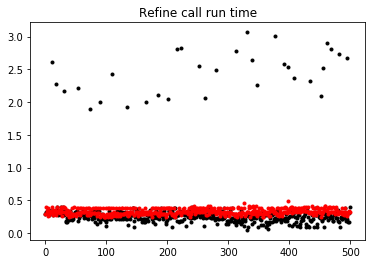

In [8]:
pp.plot(run_timeP2_ML_list,'.k',GmresRunTimeOriginal2,'.r')
pp.title('Refine call run time')
pp.savefig('Test_2.png')

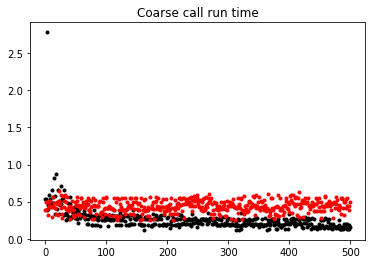

In [9]:
pp.plot(run_timeP1_ML_list,'.k',GmresRunTimeOriginal,'.r')
pp.title('Coarse call run time')
pp.savefig('Test_1.png')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:65: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


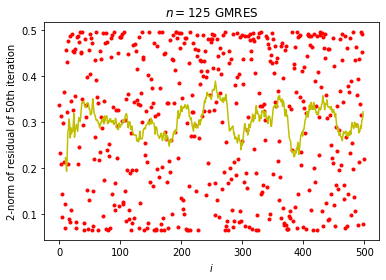

In [10]:
AVG=np.zeros((n_steps,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,n_steps)

for j in range(0,n_steps):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'.r',count[10:-1],AVG[10:-1],'y')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 50th iteration')
pp.title('$n=125$ GMRES')
pp.savefig('GMRES.png')

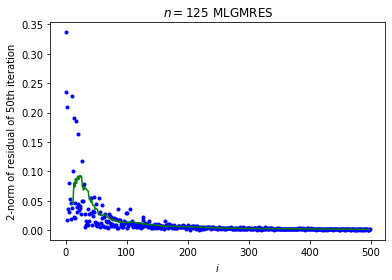

In [11]:
Err_Array_ML=np.asarray(Err_list)
AVGML=np.zeros((n_steps,1))

for j in range(0,n_steps):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)

pp.plot(count,np.asarray(Err_Array_ML),'.b',count[10:-1],AVGML[10:-1],'g')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 50th iteration')
pp.title('$n=125$ MLGMRES')
pp.savefig('MLGMRES.png')

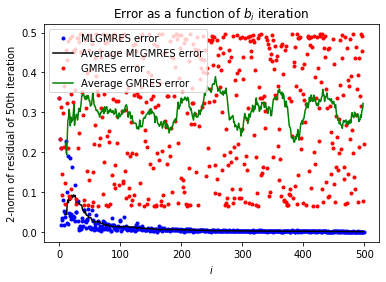

In [12]:
pp.plot(count,Err_Array_ML,'.b',label='MLGMRES error')
pp.plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
pp.plot(count,Err_Array,'.r',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 50th iteration')
pp.title('Error as a function of $b_i$ iteration ')
pp.legend(loc='best')
pp.savefig('Compare.png')

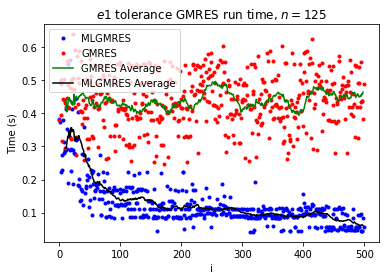

In [13]:
GmresRunTimeOriginal_AVG=np.zeros((n_steps,1))
ML_GMRES_Time_AVG=np.zeros((n_steps,1))


for j in range(0,n_steps):
    GmresRunTimeOriginal_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time_AVG[10:-1],'k', label='MLGMRES Average')




pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e1$ tolerance GMRES run time, $n=125$')
pp.legend(loc='best')
pp.savefig('Runtime.png')

#### 